# Baseline Ordinary Linear Regression Model for Benchmarking
## For Public Software dataset
The notebook reads the requested feautres, normalzies them, fits the model and saves the test results to a csv file.
<br>
model_compare/res_OLS_public_soft.csv
<br>
Created by: Karol Luszczek

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib

sys.path.append(os.path.abspath('../../src/data'))
from extract_for_model import extract_time_series
from extract_for_model import scale_time_series_single


from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# Import required paths to input files
# Change the file to import if needed
from data_links import soft_pub_IS as input_IS
from data_links import soft_pub_BS as input_BS

In [3]:
###
### PARAMETERS TO SET BY USER. DONTT EDIT THE VARIABLES NAMES. EDIT PATHS AND LISTS OF FEATURES IF NEEDED
### IF TARGET IS NOT IQ_TOTAL_REV OTHER CELLS NEEDS TO BE EDITED TOO
##
#
# Path to income statements and a list of requested features from income statements
source_IS   = input_IS
features_IS = ['IQ_EBIT','IQ_TOTAL_OTHER_OPER','IQ_EARNING_CO','IQ_TOTAL_REV']
#
# Path to balance sheets and a list of requested features from income statements
features_BS =  ['IQ_AR','IQ_RE','IQ_TOTAL_ASSETS','IQ_TOTAL_CL','IQ_TOTAL_EQUITY','IQ_TOTAL_LIAB_EQUITY']
source_BS   = input_BS
#
# Desirted path for summary of test results
output_path = 'model_compare/res_OLS_public_soft.csv'
# 
# Target variable (to be predicted)
target = 'IQ_TOTAL_REV'
#
# List of predictors, should include appendicies from data shifiting
predictors  =['IQ_TOTAL_REV-1','IQ_TOTAL_REV+0']

In [4]:
### Create output folder if needed
if (len(output_path.split('/')) > 1):
    out_folder = output_path.split('/')[:-1]
    out_folder = '/'.join(out_folder)
    if not (os.path.isdir(out_folder)):
        os.mkdir(out_folder)

In [5]:
def plot_actual_vs_predict(y_test,y_pred,target):
    """Prints the actual versus predicted values"""
    plt.figure(figsize=(6, 6))
    limit = max(np.absolute(y_test).max(),np.absolute(y_test).max())
    plt.xlim(0, limit)
    plt.ylim(0, limit)
    plt.scatter(y_pred,y_test, s=10)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.plot([-limit,limit], [-limit,limit], ls="--", c=".3")
    plt.title('Actual vs Predicted REVENUE')
    plt.grid()
    plt.show()
    

In [6]:
def correct_class(y_pred,y_test):
    """Function corrects percentage of wrongly classified growth"""
    wrong = 0
    for y1,y2 in zip(y_pred,y_test):
        test = y1*y2
        if test < 0:
            wrong +=1
    total = len(y_pred)
    print("Percentage of incorrectly classified growth %.2f %%" %(wrong/total*100))
                

In [7]:
def OLS(features,target,train_df,test_df,label):
    '''Create the OLS model with selected features'''
    X_train = np.array(train_df[features])
    y_train = np.array(train_df[target])
    X_train = sm.add_constant(X_train)

    X_test = np.array(test_df[features])
    X_test = sm.add_constant(X_test)
    y_test = np.array(test_df[target]) 

    olsmod = sm.OLS(y_train, X_train)
    olsres = olsmod.fit()
    print(label+str(features))
    print(olsres.summary())
    y_pred = olsres.predict(X_test)
    print("-----------------------------")
    print("MSE:"+str(mean_squared_error(y_test,y_pred)))
    print("MAE:"+str(mean_absolute_error(y_test,y_pred)))

    plot_actual_vs_predict(y_test,y_pred,target)
    correct_class(y_test,y_pred)

In [8]:
def OLS_norm(features,target,train_df,test_df,label):
    '''Create the OLS model with selected features'''
    '''Version for normalized features. Inverse transfrom applied at the end'''
    X_train = np.array(train_df[features])
    y_train = np.array(train_df[target])
    X_train = sm.add_constant(X_train)

    X_test = np.array(test_df[features])
    X_test = sm.add_constant(X_test)
    y_test = np.array(test_df[target]) 

    olsmod = sm.OLS(y_train, X_train)
    olsres = olsmod.fit()
    print(label+str(features))
    print(olsres.summary())
    y_pred = olsres.predict(X_test)
    print("-----------------------------")

    y_test = dict_scalers[target].inverse_transform(y_test.reshape(-1, 1))
    y_pred = dict_scalers[target].inverse_transform(y_pred.reshape(-1, 1))
    print("MSE:"+str(mean_squared_error(y_test,y_pred)))
    plot_actual_vs_predict(y_test,y_pred,target)
    correct_class(y_test,y_pred)
    return olsres

In [9]:
# Read selected data from the INTERIM file
# Read from income statements
#
# NOTE: more features than required in the model are read from interim files.
# At the time it wasn't clear which features will work best. 
# Other test models were removed from the notebook for clarity.
#
IS_train, IS_test = extract_time_series(input_path = source_IS,\
                                          features = features_IS,
                                             steps = 2,\
                                          year_min = 2012,\
                                          no_shift = False,\
                                              date = True,\
                                         quarterly = True)

# Read from Balance Sheets
BS_train, BS_test = extract_time_series(input_path = source_BS,\
                                          features = features_BS,
                                             steps = 2,\
                                          year_min = 2012,\
                                          no_shift = False,\
                                              date = True,\
                                         quarterly = True)
#
x = IS_train.pop('year')
x = IS_train.pop('quarter')
x = IS_test.pop('year')
x = IS_test.pop('quarter')
#
x = BS_train.pop('year')
x = BS_train.pop('quarter')
x = BS_test.pop('year')
x = BS_test.pop('quarter')



train_df = IS_train.set_index(['company','date']).join(BS_train.set_index(['company','date']))
test_df  = IS_test.set_index(['company','date']).join(BS_test.set_index(['company','date']))

train_df = train_df.reset_index().dropna()
test_df  = test_df.reset_index().dropna()
data_set = pd.concat([train_df,test_df]).reset_index().dropna()

====  extract_time_series metric ====
Size of data read from the file: (16407, 8)
Size of RESHAPED data without NA: (14177, 20)
No of companies in RESHAPED data: 502
No of companies with more than 1 datapoint 490
TEST  set size: (490, 20)
TRAIN set size: (9535, 20)
TEST is 5% of all available datapoints
====  extract_time_series metric ====
Size of data read from the file: (16029, 10)
Size of RESHAPED data without NA: (12226, 28)
No of companies in RESHAPED data: 474
No of companies with more than 1 datapoint 457
TEST  set size: (457, 28)
TRAIN set size: (8261, 28)
TEST is 5% of all available datapoints


In [10]:
data_set

,index,company,date,IQ_EBIT-2,IQ_TOTAL_OTHER_OPER-2,IQ_EARNING_CO-2,IQ_TOTAL_REV-2,IQ_EBIT-1,IQ_TOTAL_OTHER_OPER-1,IQ_EARNING_CO-1,...,IQ_TOTAL_ASSETS+0,IQ_TOTAL_CL+0,IQ_TOTAL_EQUITY+0,IQ_TOTAL_LIAB_EQUITY+0,IQ_AR+1,IQ_RE+1,IQ_TOTAL_ASSETS+1,IQ_TOTAL_CL+1,IQ_TOTAL_EQUITY+1,IQ_TOTAL_LIAB_EQUITY+1
0,0,IQ1004737,2012-03-31,1.228158,1.393162,-0.520597,22.193170,4.357645,3.713942,2.118456,...,168.266070,89.302216,55.802704,168.266070,69.271740,8.383482,162.615840,88.058365,53.207203,162.615840
1,1,IQ1004737,2012-06-30,4.357645,3.713942,2.118456,30.077684,-0.239797,2.170620,-1.337370,...,162.615840,88.058365,53.207203,162.615840,69.767490,8.587215,158.082400,85.536446,52.619545,158.082400
2,2,IQ1004737,2012-09-30,-0.239797,2.170620,-1.337370,26.508942,2.164441,1.675047,0.810920,...,158.082400,85.536446,52.619545,158.082400,63.937496,10.904575,151.791210,76.780320,55.713505,151.791210
3,3,IQ1004737,2012-12-31,2.164441,1.675047,0.810920,30.388638,1.556037,1.753607,0.286793,...,151.791210,76.780320,55.713505,151.791210,63.490673,11.876999,160.373140,82.988920,58.466267,160.373140
4,4,IQ1004737,2013-03-31,1.556037,1.753607,0.286793,23.794464,3.101893,4.942206,2.162115,...,160.373140,82.988920,58.466267,160.373140,62.997720,8.442230,158.792140,82.307930,58.947666,158.792140
5,5,IQ1004737,2013-06-30,3.101893,4.942206,2.162115,32.529490,1.371334,1.712648,0.056548,...,158.792140,82.307930,58.947666,158.792140,56.428370,8.841848,149.891390,74.308680,58.161144,149.891390
6,6,IQ1004737,2013-09-30,1.371334,1.712648,0.056548,24.245708,1.250708,1.542227,0.401993,...,149.891390,74.308680,58.161144,149.891390,57.549194,10.095463,153.245570,75.874650,59.183895,153.245570
7,7,IQ1004737,2013-12-31,1.250708,1.542227,0.401993,26.602600,2.067693,1.705344,0.643435,...,153.245570,75.874650,59.183895,153.245570,53.753730,9.868653,153.259490,76.187400,58.465030,153.259490
8,8,IQ1004737,2014-03-31,2.067693,1.705344,0.643435,26.356775,2.937156,4.861440,1.287832,...,153.259490,76.187400,58.465030,153.259490,60.059820,9.100618,155.202840,80.722305,56.445267,155.202840
9,9,IQ1004737,2014-06-30,2.937156,4.861440,1.287832,30.630005,0.819894,1.201428,-0.338367,...,155.202840,80.722305,56.445267,155.202840,57.054090,9.955017,148.156020,72.762190,56.419476,148.156020


In [11]:
# Normalize numerical features only (don't send dates etc. to normalization)
# Normalization pararmeters are collected in the dictionary for later inverse transformation
#
features_to_norm = data_set.columns[4:]

norm_train_df = train_df.copy()
norm_test_df = test_df.copy()

dict_scalers = {}
for feature in features_to_norm:   
    norm_train_df, norm_test_df, param = scale_time_series_single(df_train = norm_train_df,\
                                                                  df_test  = norm_test_df,
                                                                 scalemode = 'minmax',
                                                                   feature = [feature])
    dict_scalers.update(param)
    
norm_train_df = norm_train_df.reset_index()
norm_test_df  = norm_test_df.reset_index()

In [12]:
# Reshape train_df and test_df to have single entry per company
#
#
test_df = pd.concat([test_df,train_df])
#
train_df = train_df.sort_values(by = 'company')
train_df = train_df.groupby('company').tail(1)
#
test_df = test_df.sort_values(by = 'company')
test_df = test_df.groupby('company').tail(1)

################################
norm_test_df = pd.concat([norm_test_df,norm_train_df])
#
norm_train_df = norm_train_df.sort_values(by = 'company')
norm_train_df = norm_train_df.groupby('company').tail(1)
#
norm_test_df = norm_test_df.sort_values(by = 'company')
norm_test_df = norm_test_df.groupby('company').tail(1)

In [13]:
train_df = train_df.dropna()
test_df = test_df.dropna()
norm_test_df = norm_test_df.dropna()
norm_test_df = norm_test_df.dropna()

In [14]:
norm_test_df

,index,company,date,IQ_EBIT-2,IQ_TOTAL_OTHER_OPER-2,IQ_EARNING_CO-2,IQ_TOTAL_REV-2,IQ_EBIT-1,IQ_TOTAL_OTHER_OPER-1,IQ_EARNING_CO-1,...,IQ_TOTAL_ASSETS+0,IQ_TOTAL_CL+0,IQ_TOTAL_EQUITY+0,IQ_TOTAL_LIAB_EQUITY+0,IQ_AR+1,IQ_RE+1,IQ_TOTAL_ASSETS+1,IQ_TOTAL_CL+1,IQ_TOTAL_EQUITY+1,IQ_TOTAL_LIAB_EQUITY+1
6,6,IQ1004737,2013-09-30,1.371334,0.095926,0.151852,0.012043,0.019671,0.095872,0.052954,...,0.003678,0.006880,0.014598,0.003678,0.009964,0.029516,0.003761,0.007024,0.013927,0.003761
22,32,IQ100546355,2013-09-30,-1.273000,0.096341,0.151343,0.009873,0.017986,0.096341,0.052187,...,0.001031,0.000770,0.013514,0.001031,0.000161,0.029669,0.001031,0.000770,0.012854,0.001031
40,52,IQ100842126,2016-09-30,0.068003,0.095461,0.151735,0.011283,0.018884,0.095465,0.052619,...,0.001891,0.004101,0.012790,0.001891,0.003979,0.028821,0.001873,0.004062,0.012159,0.001873
48,60,IQ10214670,2012-03-31,0.396467,0.096021,0.151834,0.009813,0.019329,0.096230,0.052729,...,0.001048,0.002643,0.012632,0.001048,0.003940,0.029118,0.001039,0.002646,0.012003,0.001039
76,97,IQ1027520,2014-12-31,1.703811,0.097025,0.152470,0.013153,0.020268,0.096796,0.053655,...,0.003133,0.004789,0.015178,0.003133,0.006010,0.030385,0.003728,0.006487,0.014521,0.003728
2,5,IQ1028801,2018-07-31,1.452000,0.096814,0.152481,0.010544,0.019266,0.097183,0.053525,...,0.004552,0.003730,0.016199,0.004552,0.004592,0.029194,0.004923,0.004120,0.015488,0.004923
108,145,IQ10320771,2015-06-30,0.790643,0.094804,0.152199,0.010413,0.018813,0.095337,0.052662,...,0.000430,0.000886,0.012421,0.000430,0.001256,0.029154,0.000451,0.000855,0.011862,0.000451
4,7,IQ1034090,2018-09-30,31.773672,0.116456,0.165316,0.057066,0.036495,0.117620,0.065264,...,0.024036,0.041204,0.029221,0.024036,0.052166,0.046195,0.026401,0.039508,0.029309,0.026401
5,8,IQ10361568,2018-09-30,0.042079,0.095439,0.151798,0.008833,0.018864,0.095439,0.052695,...,0.000172,0.000173,0.012244,0.000172,0.000411,0.028586,0.000174,0.000175,0.011648,0.000174
6,9,IQ1047789,2018-09-30,-0.109277,0.096099,0.151769,0.009282,0.018995,0.095951,0.052830,...,0.000243,0.000493,0.012275,0.000243,0.000409,0.026919,0.000238,0.000507,0.011660,0.000238


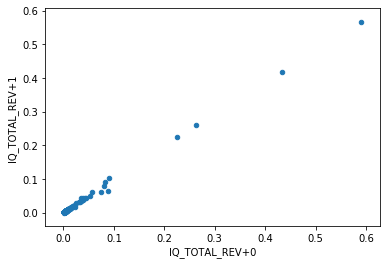

In [15]:
# Plots for visial inspection
ax1 = norm_train_df.plot.scatter(y=target+'+1', x=target+'+0')

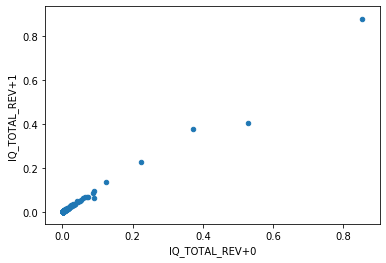

In [16]:
ax2 = norm_test_df.plot.scatter(y='IQ_TOTAL_REV+1', x='IQ_TOTAL_REV+0')

Model with normalization!['IQ_TOTAL_REV-1', 'IQ_TOTAL_REV+0']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.435e+05
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:16:18   Log-Likelihood:                 2319.8
No. Observations:                 456   AIC:                            -4634.
Df Residuals:                     453   BIC:                            -4621.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

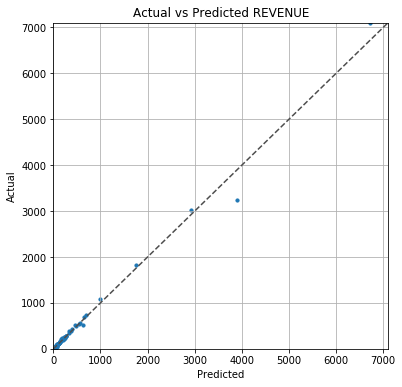

Percentage of incorrectly classified growth 0.88 %


In [17]:
# Create OLS model for normalized features
#
target_OLS = target+'+1'
label      = "Model with normalization!"
#
ols = OLS_norm(predictors,target_OLS,norm_train_df,norm_test_df,label)

In [18]:
norm_train_df = norm_train_df.set_index(['company','date'])
norm_test_df = norm_test_df.set_index(['company','date'])

In [19]:
# Make preidciton for test data
X_test = np.array(norm_test_df[predictors])
X_test = sm.add_constant(X_test)
y_test = np.array(norm_test_df[target_OLS])
#
y_pred = ols.predict(X_test)
y_test = dict_scalers[target_OLS].inverse_transform(y_test.reshape(-1, 1))
y_pred = dict_scalers[target_OLS].inverse_transform(y_pred.reshape(-1, 1))

In [20]:
# Collect test prediciton and targets for comparisons. Export to csv file
norm_test_df[target+'_target']=y_test
norm_test_df[target+'_OLS']=y_pred
res_OLS =norm_test_df[[target+'_target',target+'_OLS']]

In [21]:
res_OLS.to_csv(output_path)

In [22]:
#
# Showcasing the serialization discussed in Section 7.1 of the report.
# This notebook will do it with joblib. In OLS_base_health_public.ipnyb this will be repeated with pickle
#

In [23]:
# Create output folder if needed
#
out_folder = 'exported_models'
if not (os.path.isdir(out_folder)):
    os.mkdir(out_folder)

In [24]:
# Serialize the model
#
model_file_name = 'exported_models/MODEL_OLS_base_soft_public.sav'
joblib.dump(ols,open(model_file_name,'wb'))

In [25]:
# Load the pickled model and make prediction using the same test set
# Mind that data needs to be inversely transformed due to scaling
#
loaded_OLS = joblib.load(open(model_file_name,'rb'))
new_y_pred = loaded_OLS.predict(X_test)
new_y_pred = dict_scalers[target_OLS].inverse_transform(new_y_pred.reshape(-1, 1))

In [26]:
# Subtract new prediciton from the old. if the same sum shgould be zero
sum(new_y_pred - y_pred)

array([0.])